In [32]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, 
                           accuracy_score, classification_report, silhouette_score)
from sklearn.cluster import KMeans

# Additional libraries
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [33]:
# Load the dataset
df = pd.read_csv('data/raw/International_Education_Costs.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (907, 12)


,Country,City,University,Program,Level,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate
0,USA,Cambridge,Harvard University,Computer Science,Master,2.0,55400,83.5,2200,160,1500,1.00
1,UK,London,Imperial College London,Data Science,Master,1.0,41200,75.8,1800,485,800,0.79
2,Canada,Toronto,University of Toronto,Business Analytics,Master,2.0,38500,72.5,1600,235,900,1.35
3,Australia,Melbourne,University of Melbourne,Engineering,Master,2.0,42000,71.2,1400,450,650,1.52
4,Germany,Munich,Technical University of Munich,Mechanical Engineering,Master,2.0,500,70.5,1100,75,550,0.92


In [34]:
# Calculate Total Cost of Attendance (TCA)
df['TCA'] = df['Tuition_USD'] + (df['Rent_USD'] * 12) + df['Visa_Fee_USD'] + (df['Insurance_USD'] * df['Duration_Years'])

# Create derived features
df['Tuition_to_Rent_Ratio'] = df['Tuition_USD'] / df['Rent_USD']
df['Total_Living_Cost'] = df['Rent_USD'] * 12 + df['Insurance_USD'] * df['Duration_Years']
df['Cost_per_Year'] = df['TCA'] / df['Duration_Years']

# Create affordability tiers based on TCA quantiles
df['Affordability_Tier'] = pd.qcut(df['TCA'], q=3, labels=['Low', 'Medium', 'High'])

print("Feature engineering completed!")
print(f"\nNew features added:")
print("- TCA (Total Cost of Attendance)")
print("- Tuition_to_Rent_Ratio")
print("- Total_Living_Cost")
print("- Cost_per_Year")
print("- Affordability_Tier")

# Display summary of new features
df[['TCA', 'Affordability_Tier', 'Tuition_to_Rent_Ratio', 'Total_Living_Cost', 'Cost_per_Year']].describe()


Feature engineering completed!

New features added:
- TCA (Total Cost of Attendance)
- Tuition_to_Rent_Ratio
- Total_Living_Cost
- Cost_per_Year
- Affordability_Tier


,TCA,Tuition_to_Rent_Ratio,Total_Living_Cost,Cost_per_Year
count,907.000000,907.000000,907.000000,907.000000
mean,30552.753032,15.417505,13636.339581,11875.572308
std,22370.294736,11.365060,7083.426436,10328.950176
min,3500.000000,0.000000,2320.000000,992.500000
25%,12480.000000,4.696970,7840.000000,4523.333333
50%,19799.000000,15.000000,13100.000000,8445.000000
75%,47957.500000,24.564394,18000.000000,15324.750000
max,95160.000000,44.000000,35100.000000,64885.000000


In [35]:
# Define feature groups
categorical_features = ['Country', 'City', 'University', 'Program', 'Level']
numerical_features = ['Duration_Years', 'Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 
                     'Visa_Fee_USD', 'Insurance_USD', 'Exchange_Rate', 'Tuition_to_Rent_Ratio', 
                     'Total_Living_Cost', 'Cost_per_Year']

# Create preprocessing pipeline with handling for unknown categories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

print("Preprocessing pipeline created!")
print(f"\nFeatures to be processed:")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Print unique values in categorical columns to understand the data distribution
print("\nUnique values in categorical columns:")
for col in categorical_features:
    n_unique = df[col].nunique()
    print(f"{col}: {n_unique} unique values")


Preprocessing pipeline created!

Features to be processed:
Numerical features: 10
Categorical features: 5

Unique values in categorical columns:
Country: 71 unique values
City: 556 unique values
University: 622 unique values
Program: 92 unique values
Level: 3 unique values


In [36]:
# Prepare data for TCA regression
X = df.drop(['TCA', 'Affordability_Tier'], axis=1)
y = df['TCA']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model pipelines
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train and evaluate models
models = {
    'Linear Regression': lr_pipeline,
    'Random Forest': rf_pipeline
}

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{name} Results:")
    print(f"MAE: ${mae:,.2f}")
    print(f"RMSE: ${np.sqrt(mse):,.2f}")
    print(f"R² Score: {r2:.3f}")



Linear Regression Results:
MAE: $0.00
RMSE: $0.00
R² Score: 1.000

Random Forest Results:
MAE: $521.27
RMSE: $767.37
R² Score: 0.999


In [37]:
# Prepare data for affordability classification
X_clf = df.drop(['TCA', 'Affordability_Tier'], axis=1)  # Avoid data leakage
y_clf = df['Affordability_Tier']

# Split the data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Create classification pipelines
rf_clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

lr_clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train and evaluate classifiers
classifiers = {
    'Random Forest': rf_clf_pipeline,
    'Logistic Regression': lr_clf_pipeline
}

for name, clf in classifiers.items():
    # Train
    clf.fit(X_train_clf, y_train_clf)
    
    # Predict
    y_pred_clf = clf.predict(X_test_clf)
    
    # Evaluate
    print(f"\n{name} Classification Results:")
    print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test_clf, y_pred_clf))



Random Forest Classification Results:
Accuracy: 0.945

Classification Report:
              precision    recall  f1-score   support

        High       0.94      1.00      0.97        60
         Low       0.98      0.91      0.94        56
      Medium       0.92      0.92      0.92        66

    accuracy                           0.95       182
   macro avg       0.95      0.94      0.95       182
weighted avg       0.95      0.95      0.94       182


Logistic Regression Classification Results:
Accuracy: 0.890

Classification Report:
              precision    recall  f1-score   support

        High       0.90      1.00      0.94        60
         Low       0.92      0.84      0.88        56
      Medium       0.86      0.83      0.85        66

    accuracy                           0.89       182
   macro avg       0.89      0.89      0.89       182
weighted avg       0.89      0.89      0.89       182



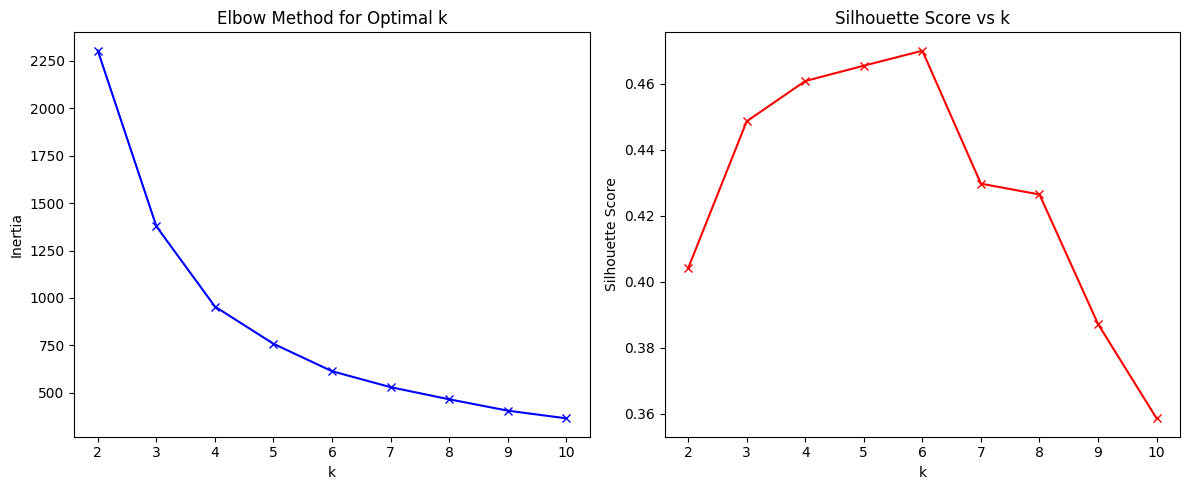


Cluster Centers (Mean Values):
               Tuition_USD     Rent_USD  Insurance_USD  Living_Cost_Index  \
Cost_Cluster                                                                
0             31707.352941  1281.617647     715.955882          69.444853   
1              4281.967213   375.081967     352.663934          45.789754   
2              5527.585034   882.823129     733.265306          69.623469   
3             39764.329897  1849.484536    1428.865979          81.585567   

              Total_Living_Cost  
Cost_Cluster                     
0                  17462.316176  
1                   5520.286885  
2                  12478.435374  
3                  26832.989691  


In [38]:
# Prepare data for clustering
cost_features = ['Tuition_USD', 'Rent_USD', 'Insurance_USD', 'Living_Cost_Index', 'Total_Living_Cost']
X_cluster = df[cost_features]

# Handle any missing values
X_cluster = X_cluster.fillna(X_cluster.mean())

# Scale the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Find optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    
    # Only calculate silhouette score if we have at least 2 clusters
    if k >= 2:
        try:
            score = silhouette_score(X_cluster_scaled, kmeans.labels_)
            silhouette_scores.append(score)
        except ValueError as e:
            print(f"Warning: Could not calculate silhouette score for k={k}: {e}")
            silhouette_scores.append(None)

# Plot elbow curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
valid_scores = [(k, score) for k, score in zip(K, silhouette_scores) if score is not None]
if valid_scores:
    ks, scores = zip(*valid_scores)
    plt.plot(ks, scores, 'rx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs k')

plt.tight_layout()
plt.show()

# Fit final clustering model with optimal k (let's say k=4 based on plots)
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cost_Cluster'] = kmeans_final.fit_predict(X_cluster_scaled)

# Analyze clusters
cluster_summary = df.groupby('Cost_Cluster')[cost_features].mean()
print("\nCluster Centers (Mean Values):")
print(cluster_summary)


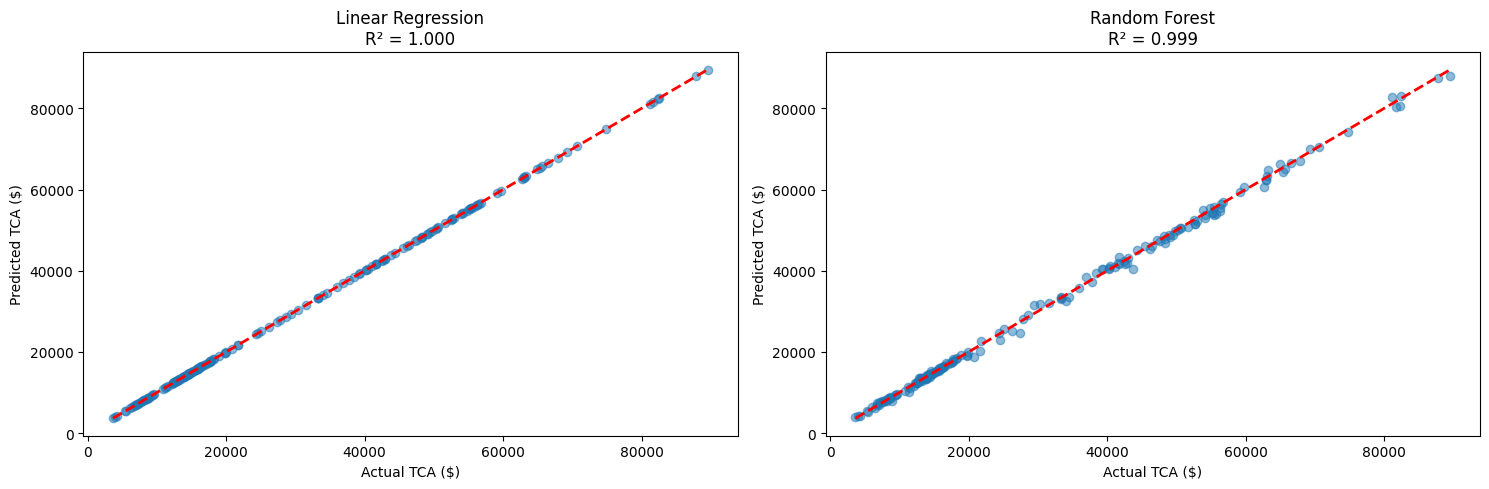

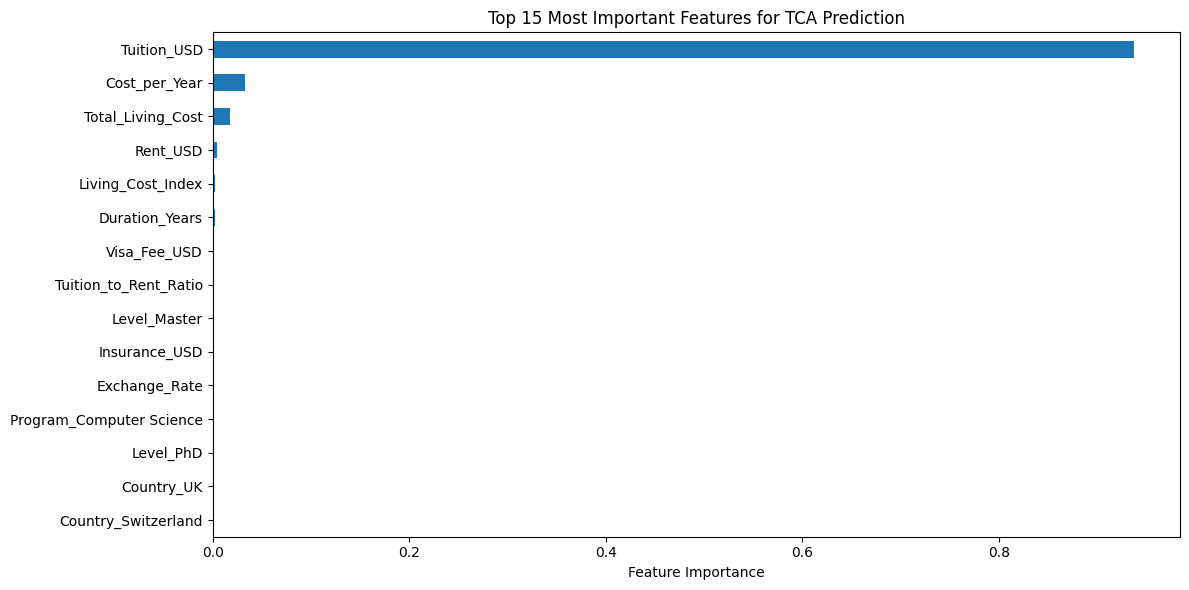

In [39]:
# Visualize regression results
plt.figure(figsize=(15, 5))

# Plot actual vs predicted for both models
for idx, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 2, idx)
    y_pred = model.predict(X_test)
    
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    
    plt.xlabel('Actual TCA ($)')
    plt.ylabel('Predicted TCA ($)')
    plt.title(f'{name}\nR² = {r2_score(y_test, y_pred):.3f}')

plt.tight_layout()
plt.show()

# For Random Forest, get feature importance
rf_model = rf_pipeline.named_steps['regressor']
feature_names = (numerical_features + 
                rf_pipeline.named_steps['preprocessor']
                .named_transformers_['cat']
                .get_feature_names_out(categorical_features).tolist())

# Plot feature importance
plt.figure(figsize=(12, 6))
importances = pd.Series(rf_model.feature_importances_, index=feature_names)
importances.sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title('Top 15 Most Important Features for TCA Prediction')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()


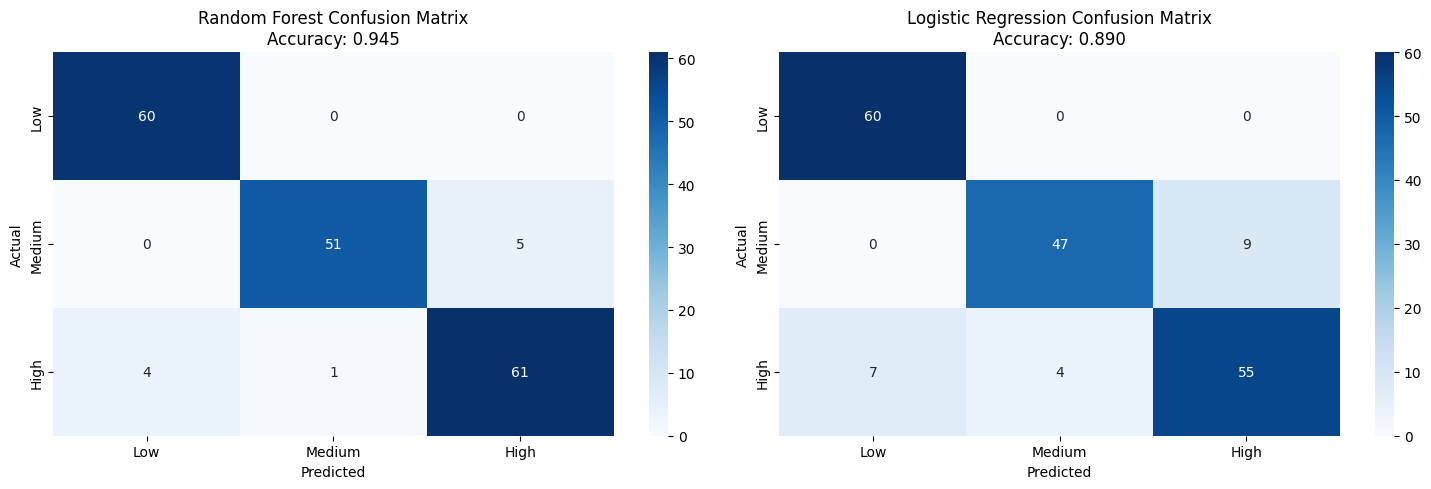

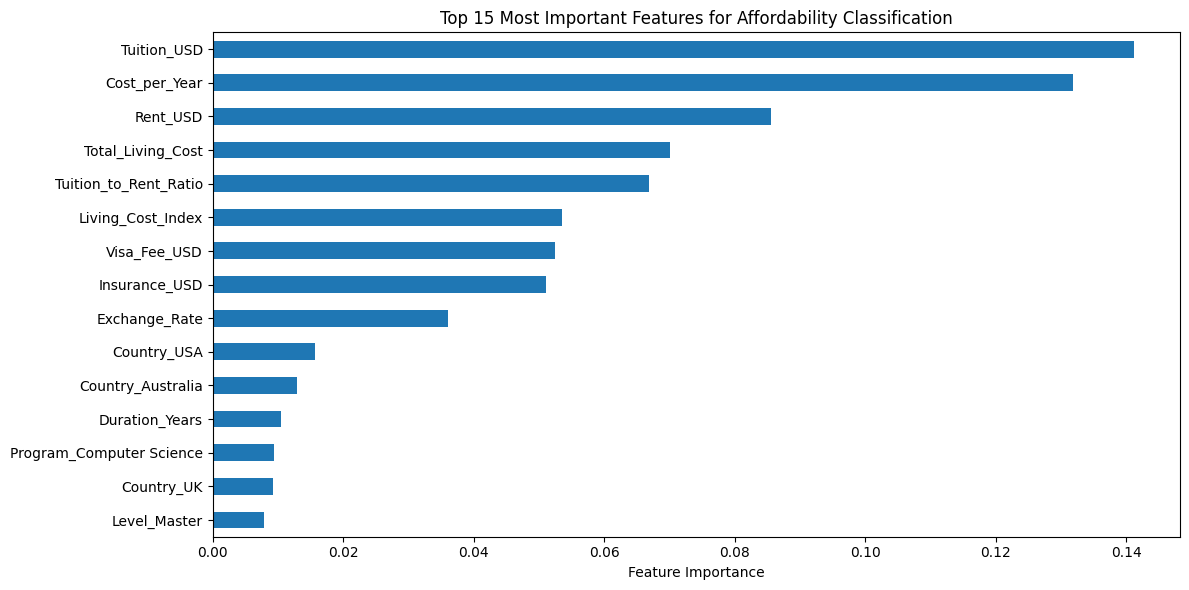

In [40]:
# Visualize classification results
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

for idx, (name, clf) in enumerate(classifiers.items(), 1):
    plt.subplot(1, 2, idx)
    
    # Get predictions
    y_pred = clf.predict(X_test_clf)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test_clf, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    
    plt.title(f'{name} Confusion Matrix\nAccuracy: {accuracy_score(y_test_clf, y_pred):.3f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# For Random Forest Classifier, show feature importance
rf_clf_model = rf_clf_pipeline.named_steps['classifier']
feature_names = (numerical_features + 
                rf_clf_pipeline.named_steps['preprocessor']
                .named_transformers_['cat']
                .get_feature_names_out(categorical_features).tolist())

plt.figure(figsize=(12, 6))
importances = pd.Series(rf_clf_model.feature_importances_, index=feature_names)
importances.sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title('Top 15 Most Important Features for Affordability Classification')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()


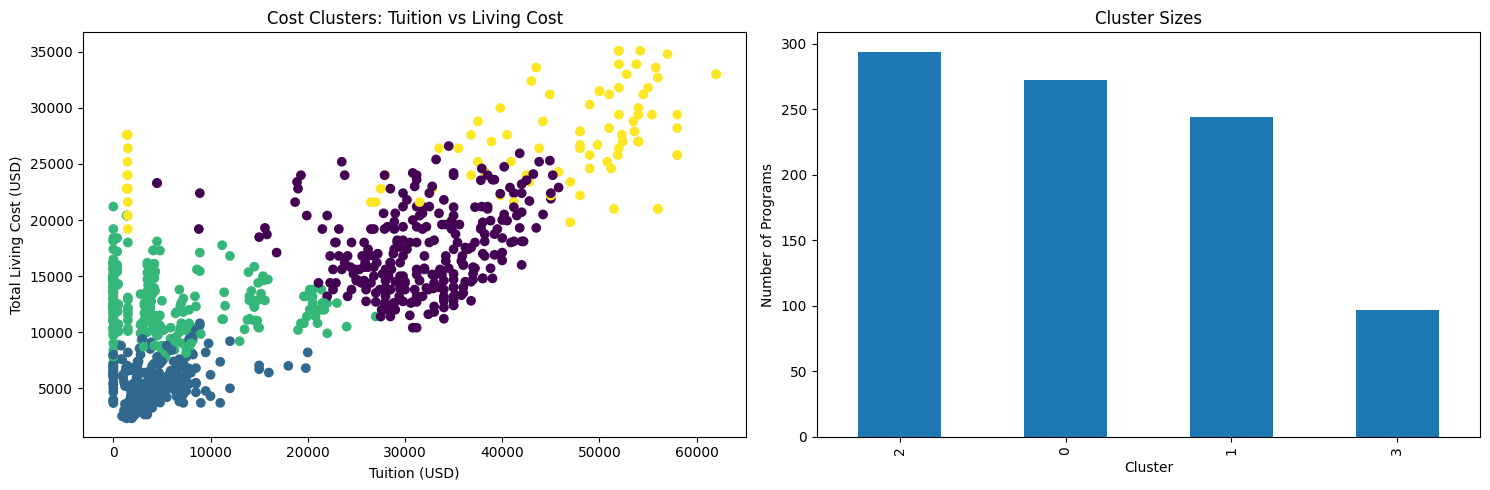


Cluster Profiles:
              Size  Avg_Tuition  Avg_Living_Cost  Avg_Total_Cost
Cost_Cluster                                                    
2              294      5527.59         12478.44        18173.20
0              272     31707.35         17462.32        49538.43
1              244      4281.97          5520.29         9911.11
3               97     39764.33         26832.99        66759.40

Top Programs in Each Cluster:

Cluster 0:
Program
Computer Science    169
Data Science         13
Data Analytics       12
dtype: int64

Cluster 1:
Program
Computer Science        42
Computer Engineering    40
Software Engineering    28
dtype: int64

Cluster 2:
Program
Computer Science           57
Data Science               28
Artificial Intelligence    22
dtype: int64

Cluster 3:
Program
Computer Science    44
Data Science        16
Data Analytics       5
dtype: int64


In [41]:
# Visualize clusters
plt.figure(figsize=(15, 5))

# Plot clusters in 2D using the two most important cost features
plt.subplot(1, 2, 1)
plt.scatter(df['Tuition_USD'], df['Total_Living_Cost'], c=df['Cost_Cluster'], cmap='viridis')
plt.xlabel('Tuition (USD)')
plt.ylabel('Total Living Cost (USD)')
plt.title('Cost Clusters: Tuition vs Living Cost')

# Plot cluster sizes
plt.subplot(1, 2, 2)
df['Cost_Cluster'].value_counts().plot(kind='bar')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Programs')

plt.tight_layout()
plt.show()

# Create cluster profile summary
cluster_profiles = pd.DataFrame()
cluster_profiles['Size'] = df['Cost_Cluster'].value_counts()
cluster_profiles['Avg_Tuition'] = df.groupby('Cost_Cluster')['Tuition_USD'].mean()
cluster_profiles['Avg_Living_Cost'] = df.groupby('Cost_Cluster')['Total_Living_Cost'].mean()
cluster_profiles['Avg_Total_Cost'] = df.groupby('Cost_Cluster')['TCA'].mean()
cluster_profiles = cluster_profiles.round(2)

print("\nCluster Profiles:")
print(cluster_profiles)

# Analyze cluster characteristics
print("\nTop Programs in Each Cluster:")
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_data = df[df['Cost_Cluster'] == cluster]
    print(cluster_data.groupby('Program').size().nlargest(3))
